In [1]:
import sys
!python --version
import numpy as np
import xarray as xr
import itertools as it
import multiprocessing as mp
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.rcsetup as rcsetup
import tensorflow as tf
import sklearn

CPU_COUNT = mp.cpu_count()
print('{} CPUs'.format(CPU_COUNT))
print('numpy version: {}'.format(np.__version__))
print('xarray version: {}'.format(xr.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('sklearn version: {}'.format(sklearn.__version__))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Python 3.7.1
8 CPUs
numpy version: 1.15.4
xarray version: 0.11.3
matplotlib version: 3.0.2
sklearn version: 0.20.1


In [2]:
X_ccsm4 = xr.open_dataset('data/rcp26/CCSM4/rcp26_CCSM4_grid.nc')
X_cesm = xr.open_dataset('data/rcp26/CESM1-CAM5/rcp26_CESM1-CAM5_grid.nc')
X_canesm = xr.open_dataset('data/rcp26/CanESM2/rcp26_CanESM2_grid.nc')
X_cnrm = xr.open_dataset('data/rcp26/CNRM-CM5/rcp26_CNRM-CM5_grid.nc')
X_miroc5 = xr.open_dataset('data/rcp26/MIROC5/rcp26_MIROC5_grid.nc')
X_all = [X_ccsm4.to_array().values, X_cesm.to_array().values, X_canesm.to_array().values, X_cnrm.to_array().values, X_miroc5.to_array().values]

N_lat = 72
N_lon = 144

(72, 144)


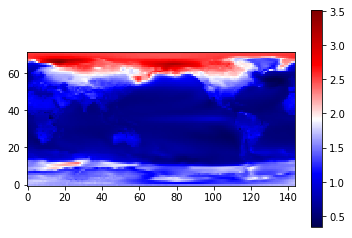

In [3]:
stdev = X_ccsm4.std(dim='time').to_array().values.reshape((72, 144))
print(stdev.shape)
plt.imshow(stdev, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

In [14]:
from keras.layers import Input, Dense, BatchNormalization
from keras.regularizers import l1,l2
from keras.models import Model

BATCH_SIZE = int(X_flat.shape[0] / 10)

input_0 = Input(batch_shape=(BATCH_SIZE, X_flat.shape[1]))
dense_1 = Dense(32, activation='relu', kernel_regularizer=l1(1.0e-5))(input_0)
dense_3 = Dense(X_flat.shape[1], activation='linear')(dense_1)

model = Model(inputs=input_0, outputs=dense_3)
model.compile(optimizer='adam', loss='mse')

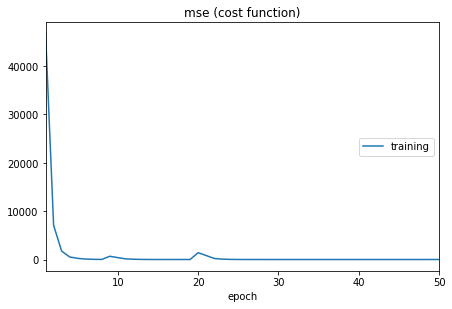

mse (cost function):
training   (min:   48.308, max: 46651.363, cur:   49.428)


In [48]:
from livelossplot.keras import PlotLossesCallback

model.fit(X_flat, X_flat, batch_size=BATCH_SIZE, epochs=50, callbacks=[PlotLossesCallback()])

In [12]:
from keras.layers import *
from keras.regularizers import l1,l2
from keras.models import Model

BATCH_SIZE = 4*144

input_0 = Input(batch_shape=(BATCH_SIZE, N_lat, N_lon, 1))
conv_0 = Conv2D(16, (3,3), strides=(2,4), activation='relu', padding='same')(BatchNormalization()(input_0))
conv_1 = Conv2D(8, (3,3), strides=(2,2), activation='relu', padding='same')(BatchNormalization()(conv_0))
conv_2 = Conv2D(4, (3,3), strides=(2,2), activation='relu', padding='same')(BatchNormalization()(conv_1))

conv_4 = Conv2D(4, (3,3), activation='relu', padding='same')(UpSampling2D((2,2))(conv_2))
conv_5 = Conv2D(8, (3,3), activation='relu', padding='same')(UpSampling2D((2,2))(conv_4))
conv_6 = Conv2D(16, (3,3), activation='relu', padding='same')(UpSampling2D((2,4))(conv_5))
conv_7 = Conv2D(1, (2,2), padding='same')(conv_6)
conv_model = Model(inputs=input_0, outputs=conv_7)

conv_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(conv_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (576, 72, 144, 1)         0         
_________________________________________________________________
batch_normalization_10 (Batc (576, 72, 144, 1)         4         
_________________________________________________________________
conv2d_19 (Conv2D)           (576, 36, 36, 16)         592       
_________________________________________________________________
batch_normalization_11 (Batc (576, 36, 36, 16)         64        
_________________________________________________________________
conv2d_20 (Conv2D)           (576, 18, 18, 8)          1160      
_________________________________________________________________
batch_normalization_12 (Batc (576, 18, 18, 8)          32        
_________________________________________________________________
conv2d_21 (Conv2D)           (576, 9, 9, 4)            132       
__________

In [13]:
X_all_t = list(map(lambda x: np.transpose(x, axes=[1,2,3,0]), X_all))
print(X_all_t[0].shape)
X_stacked = np.hstack(X_all_t).reshape((len(X_all_t)*X_all_t[0].shape[0], N_lat, N_lon, 1))
print(X_stacked.shape)

(2880, 72, 144, 1)
(14400, 72, 144, 1)


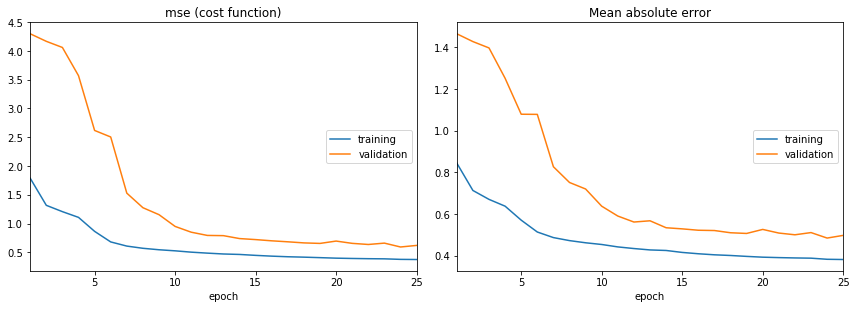

mse (cost function):
training   (min:    0.375, max:    1.787, cur:    0.375)
validation (min:    0.592, max:    4.298, cur:    0.620)

Mean absolute error:
training   (min:    0.381, max:    0.844, cur:    0.381)
validation (min:    0.484, max:    1.464, cur:    0.497)


In [14]:
from livelossplot.keras import PlotLossesCallback

conv_model.fit(X_stacked, X_stacked, batch_size=BATCH_SIZE, epochs=25, shuffle=True, validation_split=0.2, callbacks=[PlotLossesCallback()])

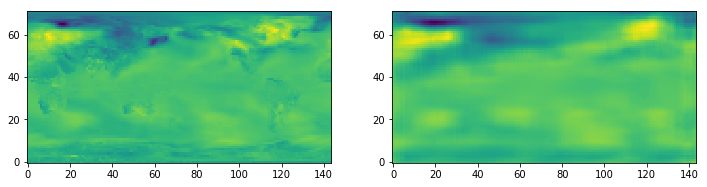

In [15]:
X_ccsm4_t0 = X_ccsm4.to_array().values.reshape((2880, 72, 144))[0,:,:]
X_pred = conv_model.predict(X_ccsm4_t0.reshape((1,72,144,1))).reshape((72,144))
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(X_ccsm4_t0, origin='lower')
plt.subplot(1,2,2)
plt.imshow(X_pred, origin='lower')
plt.show()